In [2]:
# Import neccesary programs
import requests
import bs4
from bs4 import BeautifulSoup
from lxml import html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

### Webscraping Functions

In [3]:
# function for getting location from indeed

def extract_location_from_result(loc):
    try:
        for n in loc.findAll(class_='location'):
            return n.text.strip()
    except:
        return 'None'


In [4]:
# function for getting company from indeed

def extract_company_from_result(comp):
    try:
        for n in comp.findAll(class_='company'):
            return n.text.strip()
    except:
        return 'None' 

In [5]:
# function for getting job title from indeed

def extract_jobtitle_from_result(jobtitle):
    try:
        for n in jobtitle.findAll(class_='jobtitle'):
            return n.text.strip()
    except:
        return 'None'   

In [6]:
# function to get salary from indeed

def extract_salary_from_result(sal):
    try:
        for n in sal.findAll('td', class_='snip'):
            return n.nobr
    except:
        return 'None' 

In [7]:
# function to get summary/description from indeed

def extract_summary_from_result(desc):
    try:
        for n in desc.findAll('span', class_='summary'):
            return n.text.strip()
    except:
        return 'None' 

### Select Website 

In [8]:
Location = []
Job_Title = []
Company = []
Salary = []
Description = []

url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 800
cities = ['New+York', 'Chicago', 'Boston', 'San+Francisco', 'Los+Angeles', 'Austin', 'Atlanta']
results = []
for city in set(cities):
    for start in range(0, max_results_per_city, 10):
        url = url_template.format(city,start)
        ru = requests.get(url)
        indeed = BeautifulSoup(ru.content, "lxml")
        for item in indeed.findAll('div', class_='result'):
            Location.append(extract_location_from_result(item))
            Job_Title.append(extract_jobtitle_from_result(item))
            Company.append(extract_company_from_result(item))
            Salary.append(extract_salary_from_result(item))
            Description.append(extract_summary_from_result(item))

In [9]:
# Create dataframe and name columns. Include Cities
df = pd.DataFrame([Location,Job_Title,Company,Salary,Description]).T 
  
df.columns= ['Location','Job_Title','Company','Salary','Description']

In [10]:
df['City'] = df['Location'].apply(lambda x: x.split(',')[0])

In [11]:
# Add city column
df = df[['City', 'Location', 'Job_Title', 'Company', 'Salary','Description']]

In [12]:
df.head()

,City,Location,Job_Title,Company,Salary,Description
0,Austin,"Austin, TX 78731",Data Engineer,Indeed,None,Work closely with stakeholders on the data dem...
1,Austin,"Austin, TX 78759",Senior Data Scientist - Geospatial Analytics,MaxPoint,None,Senior Data Scientist – Geospatial Analytics. ...
2,Austin,"Austin, TX 78731",Data Scientist,Indeed,None,How a Data Scientist works. As a Data Scientis...
3,Austin,"Austin, TX",Research Scientist,University of Texas at Austin,"<nobr>$4,584 a month</nobr>",Provide statistical support on research and su...
4,Austin,"Austin, TX",Staff Data Scientist,HomeAway,None,Experience in processing and analyzing Big dat...


In [13]:
df.dtypes

City           object
Location       object
Job_Title      object
Company        object
Salary         object
Description    object
dtype: object

### Cleaning Salary Data

In [14]:
df['Salary'].unique()

array([None, <nobr>$4,584 a month</nobr>,
       <nobr>$6,250 - $10,833 a month</nobr>,
       <nobr>$4,599 - $6,066 a month</nobr>, <nobr>$6,667 a month</nobr>,
       <nobr>$5,541 a month</nobr>, <nobr>$5,400 - $6,500 a month</nobr>,
       <nobr>$4,000 a month</nobr>, <nobr>$3,520 - $4,600 a month</nobr>,
       <nobr>$5,259 - $8,624 a month</nobr>,
       <nobr>$140,000 - $160,000 a year</nobr>,
       <nobr>$23.44 - $29.80 an hour</nobr>,
       <nobr>$5,259 - $6,941 a month</nobr>,
       <nobr>$45,000 - $55,000 a year</nobr>,
       <nobr>$4,500 - $4,900 a month</nobr>,
       <nobr>$120,000 - $150,000 a year</nobr>,
       <nobr>$60,000 - $80,000 a year</nobr>, <nobr>$130,000 a year</nobr>,
       <nobr>$90,000 a year</nobr>, <nobr>$5,500 - $7,500 a month</nobr>,
       <nobr>$3,519 a month</nobr>, <nobr>$80,000 - $110,000 a year</nobr>,
       <nobr>$180,000 a year</nobr>, <nobr>$150,000 a year</nobr>,
       <nobr>$110,000 a year</nobr>,
       <nobr>$104,674 - $151,358 a yea

In [15]:
# Remove rows with no salary
df = df[df.Salary.notnull()]

In [16]:
# Remove excess salary info. Convert to string
df['Salary'] = df['Salary'].apply(lambda x: str(x))
df['Salary'] = df['Salary'].apply(lambda x: x.replace('$',''))
df['Salary'] = df['Salary'].apply(lambda x: x.replace(',',''))
df['Salary'] = df['Salary'].apply(lambda x: x.replace('<nobr>',''))
df['Salary'] = df['Salary'].apply(lambda x: x.replace('</nobr>',''))



In [17]:
# Reset index

df = df.reset_index(drop=True)

In [18]:
# Parse yearly, monthly, hourly salaries
df['hourly_sal'] = df['Salary'].map(lambda x: 1 if 'hour' in x else 0)

df['monthly_sal'] = df['Salary'].map(lambda x: 1 if 'month' in x else 0)

df['yearly_sal'] = df['Salary'].map(lambda x: 1 if 'year' in x else 0)



In [19]:
# Drop monthly and hourly salaries
df_year1 = df[df.monthly_sal != 1]
df_year = df_year1[df.hourly_sal !=1]


/Users/macbook/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [20]:
df_year.head()

,City,Location,Job_Title,Company,Salary,Description,hourly_sal,monthly_sal,yearly_sal
10,Austin,"Austin, TX",Senior Machine Learning Data Scientist,All-In Analytics,140000 - 160000 a year,"Machine Learning Data Scientist. Forecasting, ...",0,0,1
14,Austin,"Austin, TX 78701 (Downtown area)",JIRA Business System Analyst,JE Compliance,45000 - 55000 a year,Ability to interact with many different types ...,0,0,1
17,Austin,"Austin, TX",Machine Learning Engineer,Volt Workforce Solutions,120000 - 150000 a year,Data mining competition experience preferred (...,0,0,1
18,Austin,"Austin, TX",LCMS Certifying Scientist,Lighthouse Recruiting,60000 - 80000 a year,Join our Medical Laboratory Scientists Groups:...,0,0,1
19,Austin,"Austin, TX",Sr. .Net Developer,Interactive Resources LLC,130000 a year,"We are looking for a collaborative, self-start...",0,0,1


In [21]:
# drop columns hourly_sal, monthly_sal, and yearly_sal
df_year = df_year.drop('hourly_sal', axis=1)
df_year = df_year.drop('monthly_sal', axis=1)
df_year = df_year.drop('yearly_sal', axis=1)

In [22]:
# Check for unique Salary values
df_year['Salary'].unique

<bound method Series.unique of 10     140000 - 160000 a year
14       45000 - 55000 a year
17     120000 - 150000 a year
18       60000 - 80000 a year
19              130000 a year
22               90000 a year
151     80000 - 110000 a year
152             180000 a year
153             150000 a year
154             110000 a year
155    104674 - 151358 a year
156             105000 a year
157    135000 - 165000 a year
158    110000 - 155000 a year
159     93257 - 137114 a year
160      75000 - 90000 a year
161             140000 a year
162     75000 - 100000 a year
164    100000 - 120000 a year
165    100000 - 130000 a year
166             125000 a year
167      75000 - 95000 a year
168             145000 a year
170              50000 a year
171             110000 a year
172              80000 a year
173      60000 - 75000 a year
174    130000 - 180000 a year
175      75000 - 90000 a year
176              70000 a year
                ...          
405             150000 a year
406    10

In [23]:
# reset index and set dataframe to df
df = df_year.reset_index(drop=True)

In [24]:
# Remove non-numeric Salary elements
df['Salary'] = df['Salary'].str.replace('a year', '')
df['Salary'] = df['Salary'].str.replace('-', ',')


In [25]:
# check for other non-numeric values
df['Salary'].unique()

array(['140000 , 160000 ', '45000 , 55000 ', '120000 , 150000 ',
       '60000 , 80000 ', '130000 ', '90000 ', '80000 , 110000 ', '180000 ',
       '150000 ', '110000 ', '104674 , 151358 ', '105000 ',
       '135000 , 165000 ', '110000 , 155000 ', '93257 , 137114 ',
       '75000 , 90000 ', '140000 ', '75000 , 100000 ', '100000 , 120000 ',
       '100000 , 130000 ', '125000 ', '75000 , 95000 ', '145000 ',
       '50000 ', '80000 ', '60000 , 75000 ', '130000 , 180000 ', '70000 ',
       '200000 ', '125000 , 175000 ', '70000 , 105000 ', '70000 , 100000 ',
       '100000 , 150000 ', '1250 a week', '34142 ', '140000 , 180000 ',
       '150000 , 190000 ', '110000 , 180000 ', '120000 ',
       '150000 , 180000 ', '93000 , 135000 ', '130000 , 150000 ',
       '100000 ', '170000 , 190000 ', '130000 , 160000 ',
       '200000 , 300000 ', '120000 , 170000 ', '54800 , 70900 ',
       '67500 , 85000 ', '120000 , 160000 ', '60000 ', '47860 , 67712 ',
       '90000 , 135000 ', '160000 ', '110000 , 1

In [26]:
# remove '1250 a week'

df = df[df.Salary.str.contains('1250') == False]
df['Salary'].unique()

array(['140000 , 160000 ', '45000 , 55000 ', '120000 , 150000 ',
       '60000 , 80000 ', '130000 ', '90000 ', '80000 , 110000 ', '180000 ',
       '150000 ', '110000 ', '104674 , 151358 ', '105000 ',
       '135000 , 165000 ', '110000 , 155000 ', '93257 , 137114 ',
       '75000 , 90000 ', '140000 ', '75000 , 100000 ', '100000 , 120000 ',
       '100000 , 130000 ', '75000 , 95000 ', '145000 ', '50000 ', '80000 ',
       '60000 , 75000 ', '130000 , 180000 ', '70000 ', '200000 ',
       '70000 , 105000 ', '70000 , 100000 ', '100000 , 150000 ', '34142 ',
       '140000 , 180000 ', '150000 , 190000 ', '110000 , 180000 ',
       '120000 ', '150000 , 180000 ', '93000 , 135000 ',
       '130000 , 150000 ', '100000 ', '170000 , 190000 ',
       '130000 , 160000 ', '200000 , 300000 ', '120000 , 170000 ',
       '54800 , 70900 ', '67500 , 85000 ', '120000 , 160000 ', '60000 ',
       '47860 , 67712 ', '90000 , 135000 ', '160000 ', '110000 , 170000 ',
       '108900 , 161000 ', '65232 , 92625 ',

In [27]:
# Create seperate columns for columns with dual salaries (Salary 1 and Salary 2)

df['Salary1'] = df['Salary'].apply(lambda x: x.split()[0])
df['Salary2'] = df['Salary'].apply(lambda x: x.split()[-1])

In [28]:
# Transform string type to int types

df['Salary1'] = pd.to_numeric(df['Salary1'], errors = 'coerce')
df['Salary2'] = pd.to_numeric(df['Salary2'], errors = 'coerce')

print df['Salary1'].dtype
print df['Salary2'].dtype

int64
float64


In [29]:
# Convert Salary column into mean of dual salaries (Salary 1 & Salary 2)
df['Salary'] = (df["Salary1"] + df["Salary2"])/2

In [30]:
# Delete columns Salary1 and Salary2
del df['Salary1']
del df['Salary2']

In [31]:
df.to_csv('webscrapingds.csv', encoding='utf-8') 

In [32]:
# Create binary for Salary
df['Salary_Y'] = df['Salary'].apply(lambda x: 1 if x > 80000 else 0)

### Running Predictions

In [33]:
# Dummy variables
df1 = pd.get_dummies(df,columns = ['City','Job_Title','Company'])


In [34]:
del df1['Location']
del df1['Description']

In [35]:
df1.dtypes

Salary                                                          float64
Salary_Y                                                          int64
City_Alpharetta                                                 float64
City_Atlanta                                                    float64
City_Austin                                                     float64
City_Bedford                                                    float64
City_Berkeley                                                   float64
City_Boston                                                     float64
City_Brisbane                                                   float64
City_Brooklyn                                                   float64
City_Cambridge                                                  float64
City_Chatsworth                                                 float64
City_Chicago                                                    float64
City_Des Plaines                                                

In [36]:
df1.head()

,Salary,Salary_Y,City_Alpharetta,City_Atlanta,City_Austin,City_Bedford,City_Berkeley,City_Boston,City_Brisbane,City_Brooklyn,...,Company_University of California Berkeley,Company_Univision communications inc,Company_VROOM,Company_Volt Workforce Solutions,Company_Wade & Wendy,Company_Workbridge Associates,Company_XOR Data Exchange,"Company_eHire, LLC",Company_ingenium,Company_kWh Analytics
0,150000.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50000.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,135000.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,70000.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,130000.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
y=df['Salary_Y'].copy()
del df1['Salary']



In [38]:
del df1['Salary_Y']
X=df1

In [39]:
# Train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 77)

In [40]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
y_pred = model.predict(X_test)
y_score = model.decision_function(X_test)

In [42]:
logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

In [43]:
gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [44]:
gs.best_params_

{'C': 5.0, 'penalty': 'l2'}

In [45]:
gs.best_estimator_

LogisticRegression(C=5.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

            predicted_over100k  predicted_under100k
over_100k                   53                    1
under_100k                   8                   21
             precision    recall  f1-score   support

          0       0.95      0.72      0.82        29
          1       0.87      0.98      0.92        54

avg / total       0.90      0.89      0.89        83



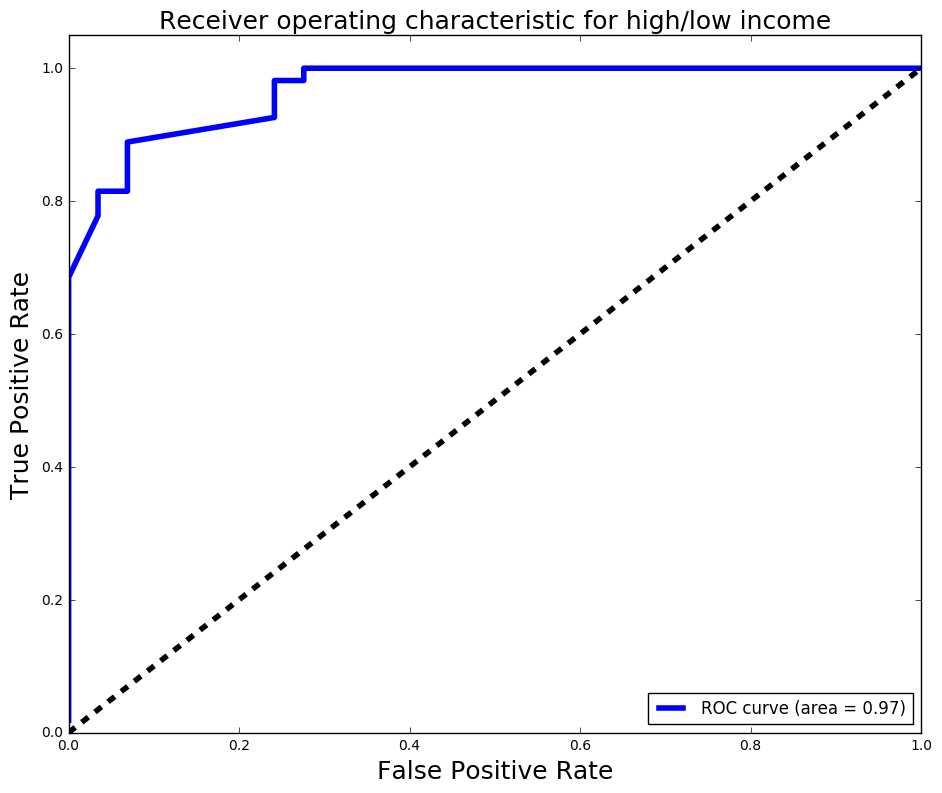

In [46]:
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over_100k', 'under_100k'],
                            columns=['predicted_over100k','predicted_under100k'])
print(confusion)
print classification_report(y_test,y_pred)
roc_auc_score(y_test, y_score)
FPR = dict()
TPR = dict()
ROC_AUC = dict()
# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])
# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high/low income', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [ ]:
#y = sub_df['income'].copy()
#del df1['income']
#del df1['country']
X_sub = df_sub
X_sub


sub_y_pred = cv_model.predict(X_sub)
y_score_sub = cv_model.decision_function(X_sub)
y_score_sub

In [ ]:
y_score_sub.reshape((len(y_score_sub),1))

In [ ]:
X.shape

In [ ]:
coef = pd.DataFrame([X.columns.values.tolist(), lr.coef_[0].tolist()], index=['features', 'coef']).T
coef.sort_values(by='coef', ascending=False)